In [ ]:
#default_exp training.token_classification

# Token Classification Tuning
> Data and Tuning API for Token Classification Tasks

In [ ]:
#hide
from nbverbose.showdoc import *
from fastcore.test import *

In [ ]:
#export
import pandas as pd
import numpy as np
from fastcore.meta import delegates
from fastcore.xtras import Path, range_of

from fastai.basics import *
from fastai.data.core import DataLoaders
from fastai.data.transforms import get_files

from adaptnlp.training.core import *
from adaptnlp.training.arrow_utils import TextNoNewLineDatasetReader
from adaptnlp.inference.token_classification import TransformersTokenTagger, TokenClassificationResult, DetailLevel

from transformers import default_data_collator, AutoModelForTokenClassification, AutoTokenizer
from datasets import Dataset, load_metric

from typing import List
from ast import literal_eval

In [ ]:
#export
_all_ = ['NERMetric']

## Datasets

In [ ]:
#export
def encode_tags(tags, encodings):
    # create an empty array of -100
    encoded_labels = np.ones(len(encodings['offset_mapping']),dtype=int) * -100
    offset_array = np.array(encodings['offset_mapping'])
    
    # set labels whose first offset position is 0 and the second is not 0
    encoded_labels[(offset_array[:,0] == 0) & (offset_array[:,1] != 0)] = tags
        
    return list(encoded_labels)

In [ ]:
#export
def _batch_tokenize(batch, tokenizer, tokenize_kwargs):
    updated_tags = [] # list of lists
    updated_batch = {} # dict of lists
    
    for tokens, tags in zip(batch['tokens'], batch['ner_tags']):
        encodings = tokenizer(tokens, **tokenize_kwargs)
        updated_tags.append(encode_tags(tags, encodings))
        
        for feat in encodings.keys():
            if (feat != 'offset_mapping'):
                if feat in updated_batch:
                    updated_batch[feat].append(encodings[feat])
                else:
                    updated_batch[feat] = [encodings[feat]]
                
    updated_batch['labels'] = updated_tags
    return updated_batch
        

In [ ]:
#export
class TokenClassificationDatasets(TaskDatasets):
    """
    A set of datasets designed for token classification
    """
    def __init__(
        self,
        train_dset:Dataset, # A training dataset
        valid_dset:Dataset, # A validation dataset
        tokenizer_name:str, # The name of a tokenizer
        tokenize:bool, # Whether to tokenize immediately
        tokenize_kwargs:dict, # kwargs for the tokenize function
        auto_kwargs:dict, # AutoTokenizer.from_pretrained kwargs
        remove_columns:list, # The columns to remove when tokenizing
        entity_mapping:dict, # A mapping of entity names to encoded labels
    ):
        
        "Constructs TaskDatasets, should not be called explicitly"
        super().__init__(
            train_dset,
            valid_dset,
            tokenizer_name,
            tokenize,
            _batch_tokenize,
            tokenize_kwargs,
            auto_kwargs,
            remove_columns,
        )
        self.entity_mapping = entity_mapping
        
    @classmethod
    def from_dfs(
        cls,
        train_df:pd.DataFrame, # A training dataframe
        token_col:str, # The name of the token column
        tag_col:str, # The name of the tag column
        entity_mapping:dict, # A mapping of entity names to encoded labels
        tokenizer_name:str, # The name of the tokenizer
        tokenize:bool=True, # Whether to tokenize immediately
        valid_df=None, # An optional validation dataframe
        split_func=None, # Optionally a splitting function similar to RandomSplitter
        split_pct=.2, # What % to split the train_df
        tokenize_kwargs:dict={}, # kwargs for the tokenize function
        auto_kwargs:dict={} # kwargs for the AutoTokenizer.from_pretrained constructor
    ):
        "Builds `TokenClassificationDatasets` from a `DataFrame` or set of `DataFrames`"
        if split_func is None: split_func = RandomSplitter(split_pct)
        if valid_df is None:
            train_idxs, valid_idxs = split_func(train_df)
            valid_df = train_df.iloc[valid_idxs]
            train_df = train_df.iloc[train_idxs]
            
        train_df = train_df[[token_col,tag_col]]
        valid_df = valid_df[[token_col,tag_col]]
        train_df = train_df.rename(columns={token_col:'tokens', tag_col: 'ner_tags'})
        valid_df = valid_df.rename(columns={token_col:'tokens', tag_col: 'ner_tags'})
        
        train_dset = Dataset.from_dict(train_df.to_dict('list'))
        valid_dset = Dataset.from_dict(valid_df.to_dict('list'))
        
        return cls(
            train_dset,
            valid_dset,
            tokenizer_name,
            tokenize,
            tokenize_kwargs,
            auto_kwargs,
            remove_columns=['tokens', 'ner_tags'],
            entity_mapping = entity_mapping
        )
    
    @classmethod
    def from_csvs(
        cls,
        train_csv:Path, # A training csv file
        token_col:str, # The name of the token column
        tag_col:str, # The name of the tag column
        entity_mapping:dict, # A mapping of entity names to encoded labels
        tokenizer_name:str, # The name of the tokenizer
        tokenize:bool=True, # Whether to tokenize immediately
        valid_csv:Path=None, # An optional validation csv
        split_func=None, # Optionally a splitting function similar to RandomSplitter
        split_pct=.2, # What % to split the train df
        tokenize_kwargs:dict={}, # kwargs for the tokenize function
        auto_kwargs:dict={}, # kwargs for the AutoTokenizer.from_pretrained constructor
        **kwargs, # kwargs for `pd.read_csv`
    ):
        "Builds `SequenceClassificationDatasets` from a single csv or set of csvs. A convience constructor for `from_dfs`"
        train_df = pd.read_csv(train_csv, **kwargs)
        if valid_csv is not None: valid_df = pd.read_csv(valid_csv, **kwargs)
        else: valid_df = None
        return cls.from_dfs(
            train_df,
            token_col,
            tag_col,
            entity_mapping,
            tokenizer_name,
            tokenize,
            valid_df,
            split_func,
            split_pct,
            tokenize_kwargs,
            auto_kwargs
        )
    
    
    @delegates(DataLoaders)
    def dataloaders(
        self,
        batch_size:int=16, # A batch size
        shuffle_train:bool=True, # Whether to shuffle the training dataset
        collate_fn:callable=None, # A custom collation function
        **kwargs # Torch DataLoader kwargs
    ):
        "Build DataLoaders from `self`"
        dls = super().dataloaders(batch_size, shuffle_train, collate_fn, **kwargs)
        dls.entity_mapping = self.entity_mapping
        return dls

In [ ]:
show_doc(TokenClassificationDatasets.from_dfs)

<h4 id="TokenClassificationDatasets.from_dfs" class="doc_header"><code>TokenClassificationDatasets.from_dfs</code><a href="__main__.py#L31" class="source_link" style="float:right">[source]</a></h4>

> <code>TokenClassificationDatasets.from_dfs</code>(**`train_df`**:`DataFrame`, **`token_col`**:`str`, **`tag_col`**:`str`, **`entity_mapping`**:`dict`, **`tokenizer_name`**:`str`, **`tokenize`**:`bool`=*`True`*, **`valid_df`**=*`None`*, **`split_func`**=*`None`*, **`split_pct`**=*`0.2`*, **`tokenize_kwargs`**:`dict`=*`{}`*, **`auto_kwargs`**:`dict`=*`{}`*)

Builds [`TokenClassificationDatasets`](/adaptnlp/training.token_classification.html#TokenClassificationDatasets) from a `DataFrame` or set of `DataFrames`

**Parameters:**


 - **`train_df`** : *`<class 'pandas.core.frame.DataFrame'>`*	<p>A training dataframe</p>


 - **`token_col`** : *`<class 'str'>`*	<p>The name of the token column</p>


 - **`tag_col`** : *`<class 'str'>`*	<p>The name of the tag column</p>


 - **`entity_mapping`** : *`<class 'dict'>`*	<p>A mapping of entity names to encoded labels</p>


 - **`tokenizer_name`** : *`<class 'str'>`*	<p>The name of the tokenizer</p>


 - **`tokenize`** : *`<class 'bool'>`*, *optional*	<p>Whether to tokenize immediately</p>


 - **`valid_df`** : *`<class 'NoneType'>`*, *optional*	<p>An optional validation dataframe</p>


 - **`split_func`** : *`<class 'NoneType'>`*, *optional*	<p>Optionally a splitting function similar to RandomSplitter</p>


 - **`split_pct`** : *`<class 'float'>`*, *optional*	<p>What % to split the train_df</p>


 - **`tokenize_kwargs`** : *`<class 'dict'>`*, *optional*	<p>kwargs for the tokenize function</p>


 - **`auto_kwargs`** : *`<class 'dict'>`*, *optional*	<p>kwargs for the AutoTokenizer.from_pretrained constructor</p>



In [ ]:
show_doc(TokenClassificationDatasets.from_csvs)

<h4 id="TokenClassificationDatasets.from_csvs" class="doc_header"><code>TokenClassificationDatasets.from_csvs</code><a href="__main__.py#L72" class="source_link" style="float:right">[source]</a></h4>

> <code>TokenClassificationDatasets.from_csvs</code>(**`train_csv`**:`Path`, **`token_col`**:`str`, **`tag_col`**:`str`, **`entity_mapping`**:`dict`, **`tokenizer_name`**:`str`, **`tokenize`**:`bool`=*`True`*, **`valid_csv`**:`Path`=*`None`*, **`split_func`**=*`None`*, **`split_pct`**=*`0.2`*, **`tokenize_kwargs`**:`dict`=*`{}`*, **`auto_kwargs`**:`dict`=*`{}`*, **\*\*`kwargs`**)

Builds [`SequenceClassificationDatasets`](/adaptnlp/training.sequence_classification.html#SequenceClassificationDatasets) from a single csv or set of csvs. A convience constructor for `from_dfs`

**Parameters:**


 - **`train_csv`** : *`<class 'pathlib.Path'>`*	<p>A training csv file</p>


 - **`token_col`** : *`<class 'str'>`*	<p>The name of the token column</p>


 - **`tag_col`** : *`<class 'str'>`*	<p>The name of the tag column</p>


 - **`entity_mapping`** : *`<class 'dict'>`*	<p>A mapping of entity names to encoded labels</p>


 - **`tokenizer_name`** : *`<class 'str'>`*	<p>The name of the tokenizer</p>


 - **`tokenize`** : *`<class 'bool'>`*, *optional*	<p>Whether to tokenize immediately</p>


 - **`valid_csv`** : *`<class 'pathlib.Path'>`*, *optional*	<p>An optional validation csv</p>


 - **`split_func`** : *`<class 'NoneType'>`*, *optional*	<p>Optionally a splitting function similar to RandomSplitter</p>


 - **`split_pct`** : *`<class 'float'>`*, *optional*	<p>What % to split the train df</p>


 - **`tokenize_kwargs`** : *`<class 'dict'>`*, *optional*	<p>kwargs for the tokenize function</p>


 - **`auto_kwargs`** : *`<class 'dict'>`*, *optional*	<p>kwargs for the AutoTokenizer.from_pretrained constructor</p>


 - **`kwargs`** : *`<class 'inspect._empty'>`*


When passing in kwargs if anything should go to the `tokenize` function they should go to `tokenize_kwargs`, and if it should go to the `Auto` class constructor, they should go to `auto_kwargs`

In [ ]:
#hide
#slow
from datasets import load_dataset

# converting original HF dataset to pandas dataframe
dsets = load_dataset('conll2003')
dset = dsets['train']
dset.set_format(type='pandas')
df = dset[:]
df = df[['tokens', 'ner_tags']]

# create entity mapping dict
entity_mapping = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-ORG',
    4: 'I-ORG',
    5: 'B-LOC',
    6: 'I-LOC',
    7: 'B-MISC',
    8: 'I-MISC'
}

# set tokenizer arguments
tokenize_kwargs = {
    'truncation':True, 
    'is_split_into_words':True, 
    'padding':'max_length', 
    'return_offsets_mapping':True
}

tset = TokenClassificationDatasets.from_dfs(
    df,
    'tokens',
    'ner_tags',
    entity_mapping,
    tokenizer_name = 'distilbert-base-uncased',
    tokenize=True,
    tokenize_kwargs = tokenize_kwargs
)

test_eq(len(tset.train), 11233)
test_eq(len(tset.valid), 2808)
test_eq(tset.train[0].keys(), ['attention_mask', 'input_ids', 'labels'])

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6. Subsequent calls will reuse this data.



No value for `max_length` set, automatically adjusting to the size of the model and including truncation
Sequence length set to: 512


In [ ]:
#hide
#slow
from datasets import load_dataset

# converting original HF dataset to pandas dataframe
dsets = load_dataset('conll2003')
dset = dsets['train']
dset.set_format(type='pandas')
df = dset[:]
df = df[['tokens', 'ner_tags']]
train_df = df.iloc[:11233]
valid_df = df.iloc[11233:]

# create entity mapping dict
entity_mapping = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-ORG',
    4: 'I-ORG',
    5: 'B-LOC',
    6: 'I-LOC',
    7: 'B-MISC',
    8: 'I-MISC'
}

# set tokenizer arguments
tokenize_kwargs = {
    'truncation':True, 
    'is_split_into_words':True, 
    'padding':'max_length', 
    'return_offsets_mapping':True
}

tset = TokenClassificationDatasets.from_dfs(
    train_df,
    'tokens',
    'ner_tags',
    entity_mapping,
    valid_df=valid_df,
    tokenizer_name = 'distilbert-base-uncased',
    tokenize=True,
    tokenize_kwargs = tokenize_kwargs
)

test_eq(len(tset.train), 11233)
test_eq(len(tset.valid), 2808)
test_eq(tset.train[0].keys(), ['attention_mask', 'input_ids', 'labels'])

Reusing dataset conll2003 (/root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


No value for `max_length` set, automatically adjusting to the size of the model and including truncation
Sequence length set to: 512


In [ ]:
#hide
#slow
from datasets import load_dataset

# converting original HF dataset to csv
dsets = load_dataset('conll2003')
dset = dsets['train']
dset.set_format(type='pandas')
df = dset[:]
df = df[['tokens', 'ner_tags']]
df['ner_tags'] = df['ner_tags'].apply(lambda x : list(x))
df['tokens'] = df['tokens'].apply(lambda x : list(x))
df.to_csv('/tmp/conll2003.csv', index=False)

# create entity mapping dict
entity_mapping = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-ORG',
    4: 'I-ORG',
    5: 'B-LOC',
    6: 'I-LOC',
    7: 'B-MISC',
    8: 'I-MISC'
}

# set tokenizer arguments
tokenize_kwargs = {
    'truncation':True, 
    'is_split_into_words':True, 
    'padding':'max_length', 
    'return_offsets_mapping':True
}

converters={'col1': literal_eval}

tset = TokenClassificationDatasets.from_csvs(
    '/tmp/conll2003.csv',
    'tokens',
    'ner_tags',
    entity_mapping,
    tokenizer_name = 'distilbert-base-uncased',
    tokenize=True,
    tokenize_kwargs = tokenize_kwargs,
    converters={'tokens': literal_eval, 'ner_tags': literal_eval}  # kwarg to pd.read_csv
)

test_eq(len(tset.train), 11233)
test_eq(len(tset.valid), 2808)
test_eq(tset.train[0].keys(), ['attention_mask', 'input_ids', 'labels'])

Reusing dataset conll2003 (/root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


No value for `max_length` set, automatically adjusting to the size of the model and including truncation
Sequence length set to: 512


In [ ]:
#hide
#slow
from datasets import load_dataset

# converting original HF dataset to csv
dsets = load_dataset('conll2003')
dset = dsets['train']
dset.set_format(type='pandas')
df = dset[:]
df = df[['tokens', 'ner_tags']]
df['ner_tags'] = df['ner_tags'].apply(lambda x : list(x))
df['tokens'] = df['tokens'].apply(lambda x : list(x))
train_df = df.iloc[:11233]
valid_df = df.iloc[11233:]
train_df.to_csv('/tmp/train.csv', index=False)
valid_df.to_csv('/tmp/valid.csv', index=False)

# create entity mapping dict
entity_mapping = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-ORG',
    4: 'I-ORG',
    5: 'B-LOC',
    6: 'I-LOC',
    7: 'B-MISC',
    8: 'I-MISC'
}

# set tokenizer arguments
tokenize_kwargs = {
    'truncation':True, 
    'is_split_into_words':True, 
    'padding':'max_length', 
    'return_offsets_mapping':True
}

converters={'col1': literal_eval}

tset = TokenClassificationDatasets.from_csvs(
    '/tmp/train.csv',
    'tokens',
    'ner_tags',
    entity_mapping,
    valid_csv = '/tmp/valid.csv',
    tokenizer_name = 'distilbert-base-uncased',
    tokenize=True,
    tokenize_kwargs = tokenize_kwargs,
    converters={'tokens': literal_eval, 'ner_tags': literal_eval}  # kwarg to pd.read_csv
)

test_eq(len(tset.train), 11233)
test_eq(len(tset.valid), 2808)
test_eq(tset.train[0].keys(), ['attention_mask', 'input_ids', 'labels'])

Reusing dataset conll2003 (/root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


No value for `max_length` set, automatically adjusting to the size of the model and including truncation
Sequence length set to: 512


## Token Classification Tuner

In [ ]:
#export
class SeqEvalMetrics():
    """
    Multi-label classification metrics for NER, using seqeval metric from HuggingFace
    """
    def __init__(
        self,
        entity_mapping:dict, # A mapping of entity names to encoded labels
    ):  
        self.metric = load_metric("seqeval")
        self.label_list = list(entity_mapping.values())
    
    # source: https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/token_classification.ipynb#scrollTo=-1bS-ATSqPq2
    def compute_metrics(
        self, 
        preds, # Predictions output by the model
        labels # Ground truth target values
    ):
        "Computes multi-label classification metrics for NER"
        predictions = preds.argmax(2)

        # Remove ignored index (special tokens)
        true_predictions = [
            [self.label_list[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [self.label_list[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        results = self.metric.compute(predictions=true_predictions, references=true_labels)
        return results
    
    def accuracy(
        self, 
        preds, # Predictions output by the model
        labels # Ground truth target values
    ):
        "Computes multi-label accuracy for NER"
        results = self.compute_metrics(preds, labels)
        return results['overall_accuracy']
    
    def precision(
        self, 
        preds, # Predictions output by the model
        labels # Ground truth target values
    ):
        "Computes multi-label precision for NER"
        results = self.compute_metrics(preds, labels)
        return results['overall_precision']
    
    def recall(
        self, 
        preds, # Predictions output by the model
        labels # Ground truth target values
    ):
        "Computes multi-label recall for NER"
        results = self.compute_metrics(preds, labels)
        return results['overall_recall']
    
    def f1(
        self, 
        preds, # Predictions output by the model
        labels # Ground truth target values
    ):
        "Computes multi-label F1 for NER"
        results = self.compute_metrics(preds, labels)
        return results['overall_f1']

In [ ]:
#export
mk_class('NERMetric', **{prop.title():prop for prop in dir(SeqEvalMetrics) 
                         if not prop.startswith('_') and prop != 'compute_metrics'},
        doc="Class for all valid NER metrics usable during fine-tuning with typo-proofing")

In [ ]:
show_doc(NERMetric, title_level=3)

<h3 id="NERMetric" class="doc_header"><code>class</code> <code>NERMetric</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>NERMetric</code>(**\*`args`**, **\*\*`kwargs`**)

Class for all valid NER metrics usable during fine-tuning with typo-proofing

**Parameters:**


 - **`args`** : *`<class 'inspect._empty'>`*

 - **`kwargs`** : *`<class 'inspect._empty'>`*


In [ ]:
#hide_input
print(f'Supported metrics:')
for val in dir(NERMetric):
    if not val.startswith('_'):
        print(f'* {val.title()}')

Supported metrics:
* Accuracy
* F1
* Precision
* Recall


In [ ]:
#export
class TokenClassificationTuner(AdaptiveTuner):
    """
    An `AdaptiveTuner` with good defaults for Token Classification tasks
    
    **Valid kwargs and defaults:**
      - `lr`:float = 0.001
      - `splitter`:function = `trainable_params`
      - `cbs`:list = None
      - `path`:Path = None
      - `model_dir`:Path = 'models'
      - `wd`:float = None
      - `wd_bn_bias`:bool = False
      - `train_bn`:bool = True
      - `moms`: tuple(float) = (0.95, 0.85, 0.95)
    
    """
    def __init__(
        self,
        dls:DataLoaders, # A set of DataLoaders
        model_name:str, # A HuggingFace model
        tokenizer = None, # A HuggingFace tokenizer
        loss_func = CrossEntropyLossFlat(), # A loss function
        metrics:List[NERMetric] = [NERMetric.Accuracy, NERMetric.F1], # Metrics to monitor the training with
        opt_func = Adam, # A fastai or torch Optimizer
        additional_cbs = None, # Additional Callbacks to have always tied to the Tuner
        expose_fastai_api = False, # Whether to expose the fastai API
        num_classes:int=None, # The number of classes
        entity_mapping:dict=None, # A mapping of entity names to encoded labels
        **kwargs, # kwargs for `Learner.__init__`
    ):
        additional_cbs = listify(additional_cbs)
        for arg in 'dls,model,loss_func,metrics,opt_func,cbs,expose_fastai'.split(','): 
            if arg in kwargs.keys(): kwargs.pop(arg) # Pop all existing kwargs
        if hasattr(dls, 'entity_mapping'): num_classes = len(dls.entity_mapping)
        else: raise ValueError('Could not extract entity mapping from DataLoaders, please pass it in as a param')
        if num_classes is None: raise ValueError('Could not extrapolate number of classes, please pass it in as a param')
        model = AutoModelForTokenClassification.from_pretrained(
            model_name, 
            num_labels=num_classes, 
            id2label=dls.entity_mapping
        )
        if tokenizer is None: tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.num_classes = num_classes
        
        self._base_metrics = SeqEvalMetrics(dls.entity_mapping)
        new_metrics = []
        for met in metrics:
            ner_met = getattr(NERMetric, met.title(), None)
            if not ner_met: raise ValueError('Metric not supported')
            else: new_metrics.append(getattr(self._base_metrics, ner_met))
        
        super().__init__(
            expose_fastai_api,
            dls = dls, 
            model = model, 
            tokenizer = tokenizer,
            loss_func = loss_func, 
            metrics = new_metrics, 
            opt_func = opt_func, 
            cbs=additional_cbs, 
            **kwargs
        )
        
    def predict(
        self,
        text:Union[List[str], str], # Some text or list of texts to do inference with
        bs:int=64, # A batch size to use for multiple texts
        grouped_entities: bool = True, # Return whole entity span strings
        detail_level:DetailLevel = DetailLevel.Low, # A detail level to return on the predictions
    ) -> dict: # A dictionary of filtered predictions
        "Predict some `text` for token classification with the currently loaded model"
        if getattr(self, '_inferencer', None) is None: self._inferencer = TransformersTokenTagger(self.tokenizer, self.model)
        
        preds = self._inferencer.predict(text, bs, grouped_entities, detail_level)
        
        return preds

In [ ]:
show_doc(TokenClassificationTuner.predict)

<h4 id="TokenClassificationTuner.predict" class="doc_header"><code>TokenClassificationTuner.predict</code><a href="__main__.py#L65" class="source_link" style="float:right">[source]</a></h4>

> <code>TokenClassificationTuner.predict</code>(**`text`**:`Union`\[`List`\[`str`\], `str`\], **`bs`**:`int`=*`64`*, **`grouped_entities`**:`bool`=*`True`*, **`detail_level`**:`DetailLevel`=*`'low'`*)

Predict some `text` for token classification with the currently loaded model

**Parameters:**


 - **`text`** : *`typing.Union[typing.List[str], str]`*	<p>Some text or list of texts to do inference with</p>


 - **`bs`** : *`<class 'int'>`*, *optional*	<p>A batch size to use for multiple texts</p>


 - **`grouped_entities`** : *`<class 'bool'>`*, *optional*	<p>Return whole entity span strings</p>


 - **`detail_level`** : *`<class 'fastcore.basics.DetailLevel'>`*, *optional*	<p>A detail level to return on the predictions</p>



**Returns**:
	
 * *`<class 'dict'>`*	<p>A dictionary of filtered predictions</p>



In [ ]:
#hide
#slow
dls = tset.dataloaders()

metrics = [NERMetric.Accuracy, NERMetric.Precision, NERMetric.Recall, NERMetric.F1]

tuner = TokenClassificationTuner(dls, 'distilbert-base-uncased', 
                                 metrics=metrics)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN t

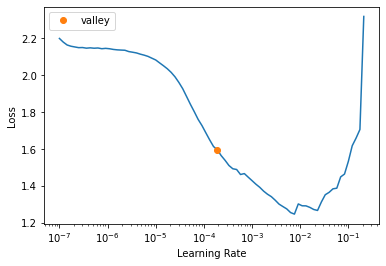

In [ ]:
#hide
#slow
lr = tuner.lr_find()

In [ ]:
#hide
#slow
from adaptnlp import Strategy

tuner.tune(3, lr=lr, strategy=Strategy.OneCycle)

epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time


KeyboardInterrupt: 

In [ ]:
#hide
#slow
tuner.predict('The company Novetta is based in McLean, Virginia')

OrderedDict([('tags',
              [[{'entity': 'B-ORG',
                 'score': 0.9966050982475281,
                 'word': 'nov'},
                {'entity': 'I-ORG',
                 'score': 0.9790855646133423,
                 'word': '##etta'},
                {'entity': 'B-LOC',
                 'score': 0.9930502772331238,
                 'word': 'mclean'}]])])